# Ocean Acidification Group
OOI Data Labs Workshop - August 2019

Revised Jan 22, 2020

**Working Title**: Impacts of Ocean Acidification on Shellfish in the Pacific Northwest

**Short Description**: Explore the relationships among atmospheric processes (wind), ocean processes (currents and upwelling), and how these processes affect ocean chemistry (pH).

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import dask
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import numpy as np
import datetime 

# Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Request Data from OOINet

* **Variables**
  1. pH
  2. pCO2
  3. Temperature
  4. Wind direction
  5. Aragonite saturation time series with level marked
* **Instruments** 
  * CE02SHSM-RID26-06-PHSEND000 - Oregon Shelf Surface Mooring, pH at 7m depth
  * CE02SHSM-SBD12-04-PCO2AA000 - Oregon Shelf Surface Mooring, pCO2 at 1m depth
  * CE01ISSM-MFD37-03-CTDBPC000 - Oregon Inshore Surface Mooring, Seawater Temperature at 25m depth
  * CE02SHSM-SBD11-06-METBKA000 - Oregon Shelf Surface Mooring, Winds @ 3m above sea-level
* **Time ranges** (Hourly averaged)
  * Exporation - One Month - 2017-05-25 00:00:00 to 2017-06-25 00:00:00
  * Application - Two Years - 2017-01-01 00:00:00 to 2018-12-31 00:00:00

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Data Requests
# request_data('CE02SHSM-RID26-06-PHSEND000','recovered_inst','phsen_abcdef_instrument',
#              '2017-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CE02SHSM-SBD12-04-PCO2AA000','telemetered','pco2a_a_dcl_instrument_air',
#              '2017-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CE01ISSM-MFD37-03-CTDBPC000','recovered_inst','ctdbp_cdef_instrument_recovered',
#              '2017-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CE02SHSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2017-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')

## 2. Load Data Files

In [0]:
# Two Years
# url_ph = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T200833266Z-CE02SHSM-RID26-06-PHSEND000-recovered_inst-phsen_abcdef_instrument/catalog.html'
# url_pco2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T200853042Z-CE02SHSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
# url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T200903473Z-CE01ISSM-MFD37-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'
# url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T200929713Z-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

# Three Years
url_ph = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T210448999Z-CE02SHSM-RID26-06-PHSEND000-recovered_inst-phsen_abcdef_instrument/catalog.html'
url_pco2_rec = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T210505178Z-CE02SHSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
url_pco2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T212957132Z-CE02SHSM-SBD12-04-PCO2AA000-telemetered-pco2a_a_dcl_instrument_air/catalog.html'
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T210518095Z-CE01ISSM-MFD37-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200122T210643615Z-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'


In [0]:
def get_data(url):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d)
  selected_datasets = sorted(selected_datasets)
  # print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
# Load Data
data_ph = get_data(url_ph)
data_pco2 = get_data(url_pco2)
data_ctd = get_data(url_ctd)
data_met = get_data(url_met)

In [0]:
# Some cleaning
data_pco2['partial_pressure_co2_atm'] = data_pco2['partial_pressure_co2_atm'].where((data_pco2['partial_pressure_co2_atm']>100) & (data_pco2['partial_pressure_co2_atm']<500))
data_pco2['partial_pressure_co2_ssw'] = data_pco2['partial_pressure_co2_ssw'].where((data_pco2['partial_pressure_co2_ssw']>100) & (data_pco2['partial_pressure_co2_ssw']<500))
data_pco2['partial_pressure_co2_atm'] = data_pco2['partial_pressure_co2_atm'].where(reject_outliers(data_pco2['partial_pressure_co2_atm']))
data_pco2['partial_pressure_co2_ssw'] = data_pco2['partial_pressure_co2_ssw'].where(reject_outliers(data_pco2['partial_pressure_co2_ssw']))

data_ph['phsen_abcdef_ph_seawater'] = data_ph['phsen_abcdef_ph_seawater'].where(reject_outliers(data_ph['phsen_abcdef_ph_seawater']))

## Plot the Data

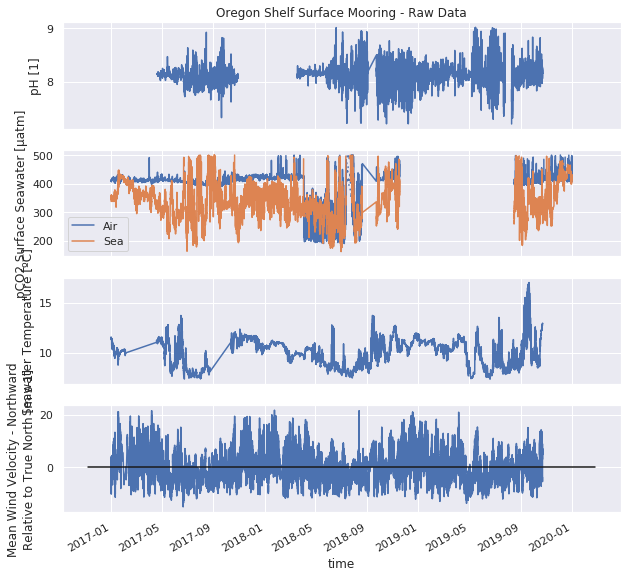

In [10]:
# Plot the data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
data_ph.phsen_abcdef_ph_seawater.plot(ax=ax1)
data_pco2.partial_pressure_co2_atm.plot(ax=ax2,label='Air')
data_pco2.partial_pressure_co2_ssw.plot(ax=ax2,label='Sea')
data_ctd.ctdbp_seawater_temperature.plot(ax=ax3)
data_met.met_windavg_mag_corr_north.plot(ax=ax4)

# Add 0 line for Wind
xlim = ax1.get_xlim()
ax4.plot([xlim[0],xlim[1]],[0,0],'k')
# Add line at 2mg/L for DO
# ax1.plot([xlim[0],xlim[1]],[2,2],'r--')
# ax3.set_xlim(xlim);

ax2.legend()

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');
ax1.set_title('Oregon Shelf Surface Mooring - Raw Data')

plt.savefig("endurance_raw.png");

## Average and Merge

In [11]:
%%time
# Average Datasets
avgint='1H'
a = data_ph[['phsen_abcdef_ph_seawater']].load().resample(time=avgint).mean()
b = data_pco2[['partial_pressure_co2_atm','partial_pressure_co2_ssw']].load().resample(time=avgint).mean()
c = data_ctd[['ctdbp_seawater_temperature','practical_salinity']].load().resample(time=avgint).mean()
d = data_met[['met_windavg_mag_corr_east','met_windavg_mag_corr_north','air_temperature','sea_surface_temperature','met_salsurf']].load().resample(time=avgint).mean()


CPU times: user 2min 3s, sys: 7.78 s, total: 2min 10s
Wall time: 2min 5s


In [12]:
# Merge the datasets
a = a.rename({'phsen_abcdef_ph_seawater':'pH'})
b = b.rename({'partial_pressure_co2_atm':'pCO2 Air',
              'partial_pressure_co2_ssw':'pCO2 Seawater'})
c = c.rename({'ctdbp_seawater_temperature':'Seawater Temperature',
              'practical_salinity':'Salinity'})
d = d.rename({'met_windavg_mag_corr_east':'East Winds',
              'met_windavg_mag_corr_north':'North Winds',
              'air_temperature':'Air Temperature',
              'sea_surface_temperature':'Surface Temperature',
              'met_salsurf':'Surface Salinity'})

data = xr.merge([a,b,c,d]).to_dataframe()

# Print the first few rows
data.head()

,pH,pCO2 Air,pCO2 Seawater,Seawater Temperature,Salinity,East Winds,North Winds,Air Temperature,Surface Temperature,Surface Salinity
time,,,,,,,,,,
2017-01-01 00:00:00,NaN,410.996960,338.166485,11.525613,31.802061,1.919396,-0.250082,6.429450,10.369900,31.631327
2017-01-01 01:00:00,NaN,411.152970,346.197685,11.527976,31.814405,4.636664,-2.894962,7.409250,10.438466,31.658676
2017-01-01 02:00:00,NaN,411.190164,351.973906,11.454036,31.824322,5.790897,-1.626279,8.005800,10.436934,31.644223
2017-01-01 03:00:00,NaN,411.281068,351.143785,11.422609,31.830489,5.214713,-6.246210,7.820200,10.413050,31.592517
2017-01-01 04:00:00,NaN,412.929572,353.401407,11.464325,31.837565,6.232284,-6.504621,8.732202,10.418015,31.595512


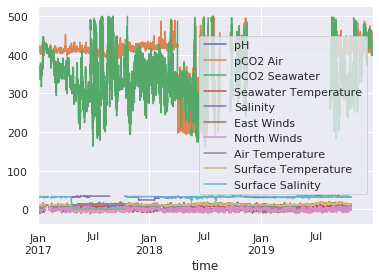

In [13]:
# Test plot
data.plot()

In [0]:
# Export to CSV
data.to_csv('endurance_oa.csv')

## More Plots

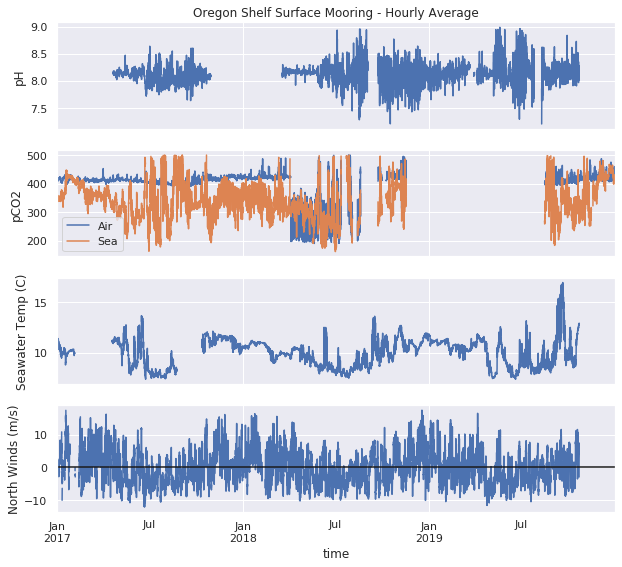

In [15]:
# Plot the hourly averaged data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
data['pH'].plot(ax=ax1)
data['pCO2 Air'].plot(ax=ax2,label='Air')
data['pCO2 Seawater'].plot(ax=ax2,label='Sea')
data['Seawater Temperature'].plot(ax=ax3)
data['North Winds'].plot(ax=ax4)

# Add 0 line for Wind
xlim = ax1.get_xlim()
ax4.plot([xlim[0],xlim[1]],[0,0],'k')

ax2.legend()
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

ax1.set_ylabel('pH')
ax2.set_ylabel('pCO2')
ax3.set_ylabel('Seawater Temp (C)');
ax4.set_ylabel('North Winds (m/s)');

ax1.set_title('Oregon Shelf Surface Mooring - Hourly Average')

plt.savefig("endurance_1hr.png");

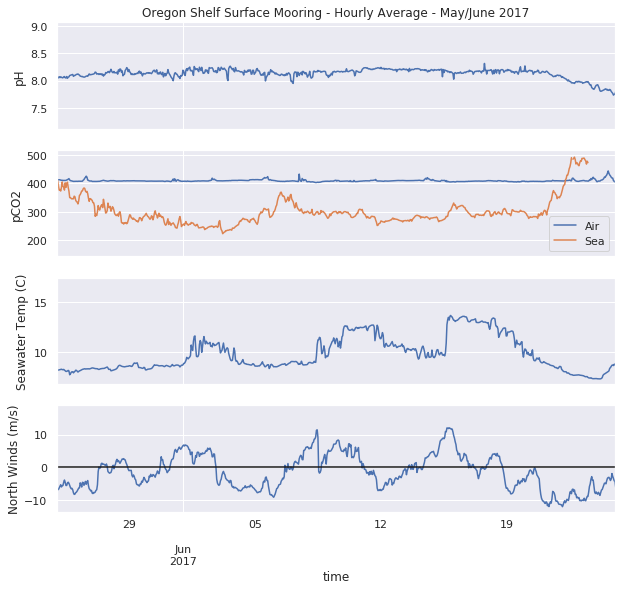

In [16]:
# Plot 1 month
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
data['pH'].plot(ax=ax1)
data['pCO2 Air'].plot(ax=ax2,label='Air')
data['pCO2 Seawater'].plot(ax=ax2,label='Sea')
data['Seawater Temperature'].plot(ax=ax3)
data['North Winds'].plot(ax=ax4)

# Add 0 line for Wind
xlim = ax1.get_xlim()
ax4.plot([xlim[0],xlim[1]],[0,0],'k')

ax1.set_xlim([datetime.date(2017, 5, 25), datetime.date(2017, 6, 25)])

ax2.legend()
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

ax1.set_ylabel('pH')
ax2.set_ylabel('pCO2')
ax3.set_ylabel('Seawater Temp (C)');
ax4.set_ylabel('North Winds (m/s)');

ax1.set_title('Oregon Shelf Surface Mooring - Hourly Average - May/June 2017')

plt.savefig("endurance_1hr_focus.png");

## Questions
* How do you calculate Aragonite Saturation?
* The 2017-2018 data is quite gappy, do you want to include 2019 as well or instead?
* I included a few other variables in the output file (salinity, surface temp/sal).  Not sure if they're needed.
* The spring/summer pCO2 Air data looks bad, but it's moot if Air is not needed.